# **Proyecto 10a**: Estudio del rendimiento de RNNs y su comportamiento a distintos largos de secuencia.
#Inteligencia Computacional EL4106-1 Primavera 2023

**Profesor**
- Pablo Estévez

**Profesor Auxiliar**
- Juan Urrutia

**Ayudante**
- Alejandro Luzanto

**Estudiantes:**
- Agustín González
- Diego Torreblanca

## Importar librerías y archivos

Importamos librerías a utilizar

In [3]:
import torch
import torch.nn as nn
import torchaudio
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
from tqdm.notebook import tqdm
from pprint import pprint

Importamos lista con archivos de audio que serán usados en validación, entrenamiento y testeo.

In [4]:
files_dict = {
    "train_list.txt": "1rkwGTHlMWp1HAUSZK2zMhzzYGcb7Tb3y",
    "test_list.txt": "1dsMqujN1uFEHjZy77d2K64NwIiN4vibv",
    "val_list.txt": "1Q6nP5QZFvSO3sP6-1_Q7aIXgiod6LsJj"
}

for file_name, file_url in files_dict.items():

    url = f'https://drive.usercontent.google.com/download?id={file_url}&export=download'
    urllib.request.urlretrieve(url, "./" + file_name)

## Carga de los datasets

In [5]:
# Importar Dataset
# Clase que nos permite cargar el dataset y recorrer solo los archivos que nos interesa recorrer
# por cada caso (validación, entrenamiento, testeo)
class CustomSpeechCommands(torchaudio.datasets.SPEECHCOMMANDS):

    def __init__(self, subset_to_download: str = "all"):
        super().__init__("", download=True, subset=None, url="speech_commands_v0.02")

        if subset_to_download == "validation":
            self._walker = self.load_list("val_list.txt")
        elif subset_to_download == "testing":
            self._walker = self.load_list("test_list.txt")
        elif subset_to_download == "training":
            self._walker = self.load_list("train_list.txt")
        else:
            raise RuntimeError("Invalid subset")


    def load_list(self, *filenames):
        output = []
        for filename in filenames:
            filepath = os.path.join("", filename)
            with open(filepath) as fileobj:
                output += [os.path.normpath(
                    os.path.join("./SpeechCommands/speech_commands_v0.02/",
                                 line.strip())) for line in fileobj]
        return output

# Se crean los datasets
train_dataset = CustomSpeechCommands("training")
val_dataset = CustomSpeechCommands("validation")
test_dataset = CustomSpeechCommands("testing")

# Se definen las labels que serán válidas
VALID_LABELS = ["yes", "no", "up", "down", "left", "right", "on",
"off", "stop", "go", "unknown word"]

# Cantidad de MFCC (coeficientes)
N_MFCC = 20

def label_to_tensor(label: str) -> torch.tensor:
    """Dado una etiqueta entrega un tensor con un número que representa el índice de la etiqueta"""

    if label.lower() in VALID_LABELS:
        index = VALID_LABELS.index(label)
    else:
        index = len(VALID_LABELS) - 1

    return torch.tensor(index)

100%|██████████| 2.26G/2.26G [00:21<00:00, 111MB/s]


In [18]:
def collate_and_transform(batch):
    """Procesa los audios y etiquetas para que tengan el formato adecuado"""
    WINDOW_SIZE = 40e-3 # Ventana de 40 ms de forma predeterminada
    # WINDOW_SIZE = 80e-3 # Ventana de 80 ms para estudiar la red RNN Vanilla
    # WINDOW_SIZE = 120e-3 # Ventana de 120 ms para estudiar la red RNN Vanilla
    SAMPLE_RATE = 16_000
    N_FFT = int(SAMPLE_RATE * WINDOW_SIZE)
    HOP_LENGTH = N_FFT // 2 # Overlap del 50%

    # Se recupera cada audio y etiqueta del batch para procesar
    audios, labels = [], []

    for audio, _, label, *_ in batch:
        audios.append(audio.t())
        labels.append(label_to_tensor(label))
    # Tensor con las etiquetas
    labels = torch.stack(labels)

    # Los audios tienen largos distintos, por lo que se rellenan con ceros para que queden todos
    # iguales.
    audios = torch.nn.utils.rnn.pad_sequence(audios,
                                              batch_first=True)\
                                .squeeze()

    # Se crea el transformador a MCC
    mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC,
                                   melkwargs= {
                                       "hop_length": HOP_LENGTH,
                                       "n_fft": N_FFT
                                   })
    # Se calculan los MFCC de los audios
    mfcc_vals = mfcc(audios)
    # Se calcula los delta de los audios
    delta = torchaudio.functional.compute_deltas(mfcc_vals) # (batch, 20, 51) cambiar la cantidad de features
    # Se calcula los delta-delta de los audios
    delta2 = torchaudio.functional.compute_deltas(delta)
    # Se concatenan las 3 características, compartiendo la dimensión del tiempo
    audios = torch.cat((mfcc_vals, delta, delta2), dim=1).permute(0, 2, 1) # BATCH, LENGTH, INPUT

    return audios, labels

# Dataloaders para los 3 tipos de audios
BATCH_SIZE = 128
SHUFFLE_DL = True

# Se asume que se usará GPU
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    collate_fn=collate_and_transform,
    pin_memory=True,
    num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    collate_fn=collate_and_transform,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    collate_fn=collate_and_transform,
    pin_memory=True)

Escuchamos uno de los audios

In [ ]:
# Zero
SAMPLE_RATE = 16000
ipd.Audio(train_dataset[-1][0], rate=SAMPLE_RATE)

## Gráficos

Gráficos de las curvas de entrenamiento y validación

In [19]:
def show_curves(all_curves, model_name):

    min = np.inf
    for curve in all_curves:
        new_min = len(curve["val_loss"])
        min = new_min if new_min < min else min

    for curve in all_curves:
        for i in curve.keys():
            curve[i] = curve[i][:min]

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training for ' + model_name)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training for ' + model_name)
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

Métricas y Matriz de Confusión

In [20]:
def confusion_matrix(model, dataloader, model_name):
    model.cpu()
    model.eval()
    y_true = []
    y_pred = []

    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(model_name + " metrics\n")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=VALID_LABELS,xticks_rotation=30)
    plt.title("Confusion Matrix for " + model_name)
    plt.show()

## Funciones de entrenamiento (clase de entrenamiento?)

In [21]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    epoch_tolerance=3
):
    if use_gpu:
        model.cuda()

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    early_stopping = EarlyStopping(epoch_tolerance)

    post = {
        "val_loss": 0,
        "val_acc": 0,
        "train_loss": 0,
        "train_acc": 0
    }

    for epoch in range(epochs):

        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        description = f"Running Epoch {epoch+1}"

        my_pbar = tqdm(train_loader, leave=False)
        my_pbar.set_description(description)

        # Entrenamiento del modelo
        model.train()

        for x_batch, y_batch in my_pbar:
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            my_pbar.set_postfix(post)

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        post["val_loss"] = val_loss
        post["val_acc"] = val_acc
        post["train_acc"] = train_acc
        post["train_loss"] = train_loss

        # Early Stopping
        if early_stopping(val_loss):
            pprint(post)
            print("\nEarly stopping.")
            break


    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Modelo LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()
        self.lstm = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS))
        )

    def forward(self, x):
        _, (h, _) = self.lstm(x)

        return self.net(h[-1])

### Entrenamiento del Modelo LSTM

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

lstm_all_curves = []
lstm_times = []

for train_run in range(n_trains):
    lstm_model = LSTMModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        lstm_model,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    lstm_all_curves.append(curves)
    lstm_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(lstm_times):.2f} +- {np.std(lstm_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9726373524789695,
 'train_loss': 0.08504663703869779,
 'val_acc': 0.9243870967741935,
 'val_loss': 0.2540181003078338}

Early stopping.

Tiempo total de entrenamiento: 260.8914 [s]
Tiempo de entrenamiento promedio de 1 corridas: 260.89 +- 0.00 [s]


Graficamos los resultados del entrenamiento

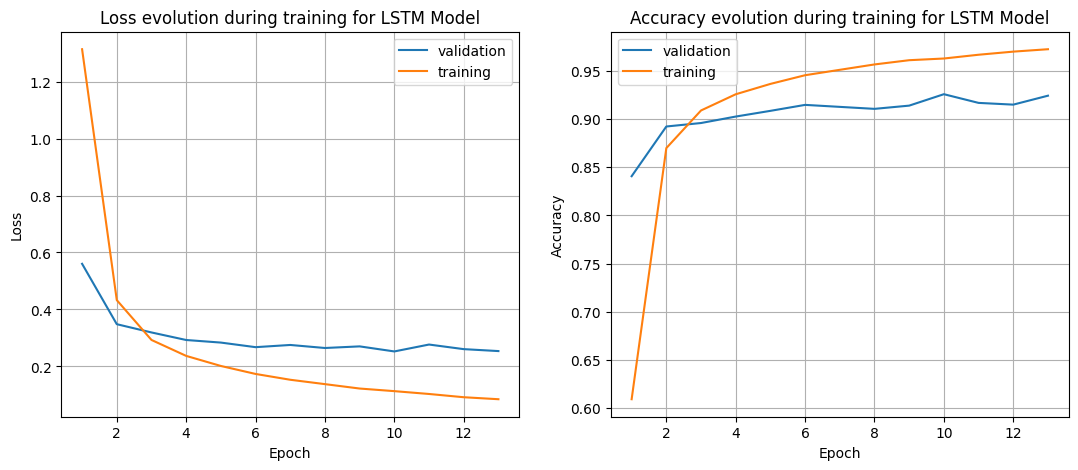

In [ ]:
show_curves(lstm_all_curves, "LSTM Model")

Graficamos la matriz de confusión y obtenemos las métricas

LSTM Model metrics

Accuracy: 92.08%
Precision: 92.07%
Recall: 92.15%
F1-score: 92.09%


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


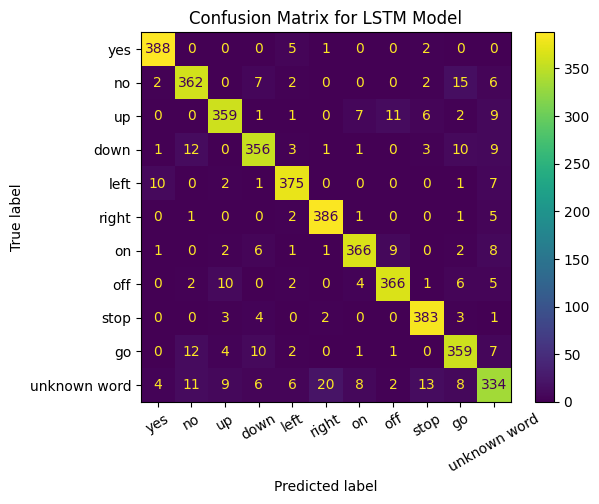

In [ ]:
confusion_matrix(lstm_model, test_loader, "LSTM Model")

## Modelo GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()
        self.gru = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS))
        )

    def forward(self, x):
        _, h = self.gru(x)
        return self.net(h[-1])

### Entrenamiento del Modelo GRU

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

gru_all_curves = []
gru_times = []

for train_run in range(n_trains):
    model_gru = GRUModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_gru,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    gru_all_curves.append(curves)
    gru_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(gru_times):.2f} +- {np.std(gru_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.973192000739531,
 'train_loss': 0.08883735856806792,
 'val_acc': 0.9220645161290323,
 'val_loss': 0.25247841581990643}

Early stopping.

Tiempo total de entrenamiento: 161.9416 [s]
Tiempo de entrenamiento promedio de 1 corridas: 161.94 +- 0.00 [s]


Graficamos los resultados del entrenamiento

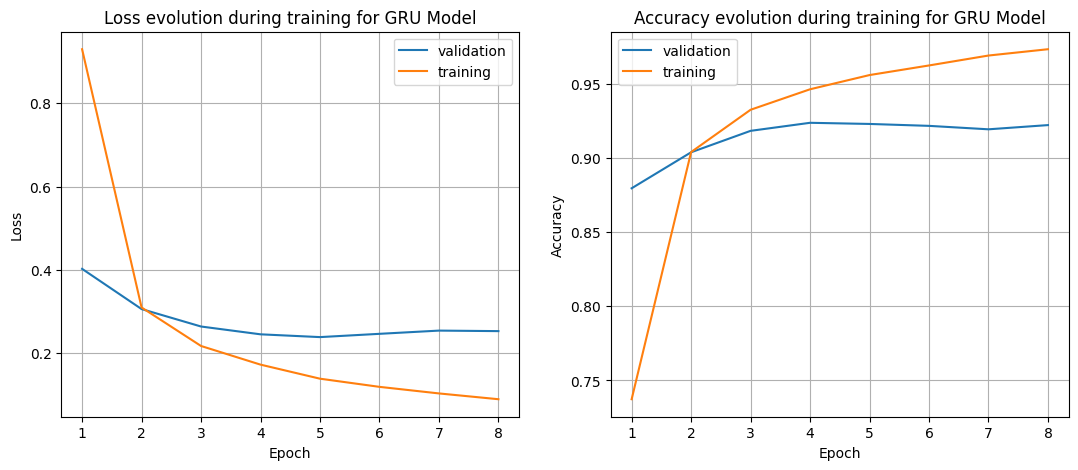

In [ ]:
show_curves(gru_all_curves, "GRU Model")

Graficamos la matriz de confusión y obtenemos las métricas

GRU Model metrics

Accuracy: 91.35%
Precision: 91.49%
Recall: 91.41%
F1-score: 91.37%


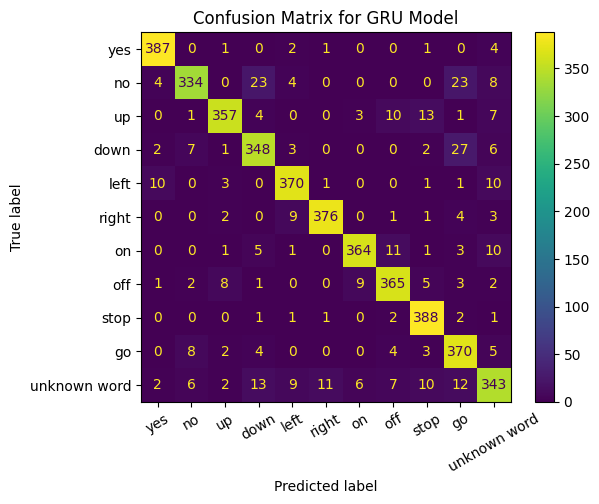

In [ ]:
confusion_matrix(model_gru, test_loader, "GRU Model")

## Modelo Vanilla RNN

In [22]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
    ):
        super().__init__()
        self.rnn = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS))
        )

    def forward(self, x):
        _, h = self.rnn(x)
        return self.net(h[-1])

### Entrenamiento del Modelo Vanilla RNN (Ventana de 40 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves = []
rnn_times = []

for train_run in range(n_trains):
    model_rnn = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves.append(curves)
    rnn_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times):.2f} +- {np.std(rnn_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.2062058977598373,
 'train_loss': 2.1017058367604737,
 'val_acc': 0.18787096774193549,
 'val_loss': 2.1510439678930466}

Early stopping.

Tiempo total de entrenamiento: 295.6012 [s]
Tiempo de entrenamiento promedio de 1 corridas: 295.60 +- 0.00 [s]


Graficamos los resultados del entrenamiento

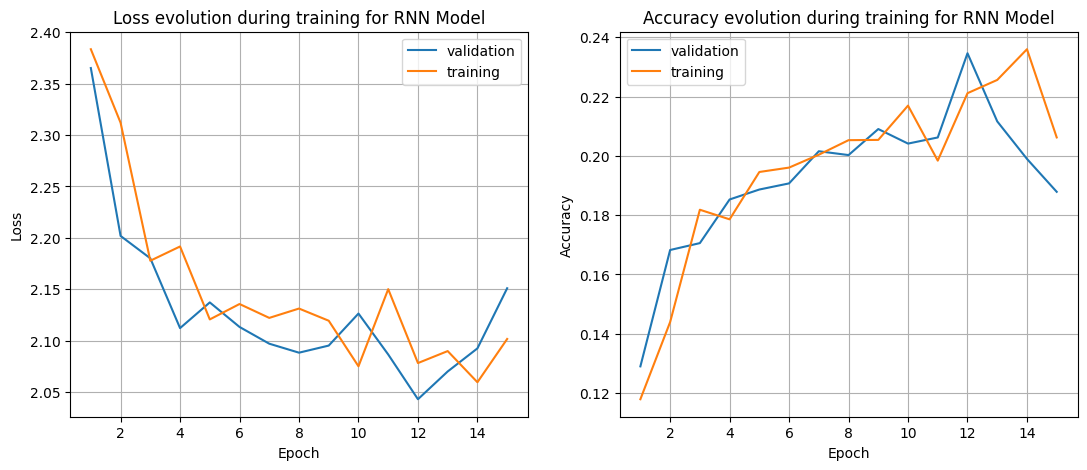

In [ ]:
show_curves(rnn_all_curves, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 19.72%
Precision: 21.99%
Recall: 19.66%
F1-score: 16.95%


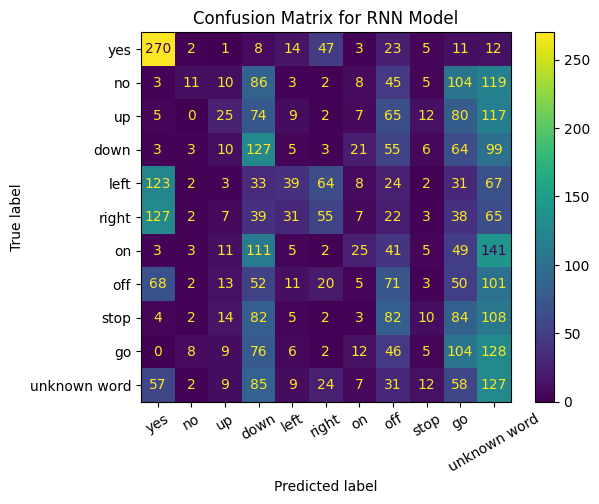

In [ ]:
confusion_matrix(model_rnn, test_loader, "RNN Model")

### Entrenamiento del Modelo Vanilla RNN (Ventana de 80 ms)

In [11]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_80 = []
rnn_times_80 = []

for train_run in range(n_trains):
    model_rnn_80 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_80,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_80.append(curves)
    rnn_times_80.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_80):.2f} +- {np.std(rnn_times_80):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]


Tiempo total de entrenamiento: 347.4747 [s]
Tiempo de entrenamiento promedio de 1 corridas: 347.47 +- 0.00 [s]


Graficamos los resultados del entrenamiento

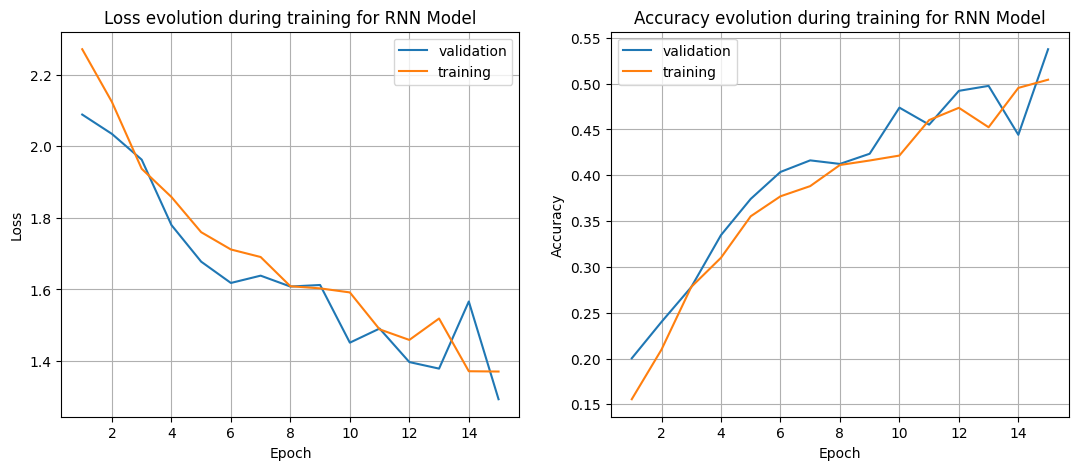

In [14]:
show_curves(rnn_all_curves_80, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 53.00%
Precision: 52.22%
Recall: 53.19%
F1-score: 51.98%


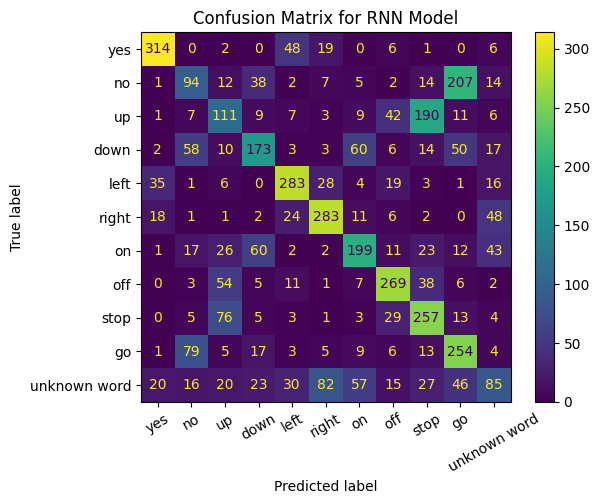

In [15]:
confusion_matrix(model_rnn_80, test_loader, "RNN Model")

RNN Model metrics

Accuracy: 54.01%
Precision: 52.74%
Recall: 54.25%
F1-score: 52.56%


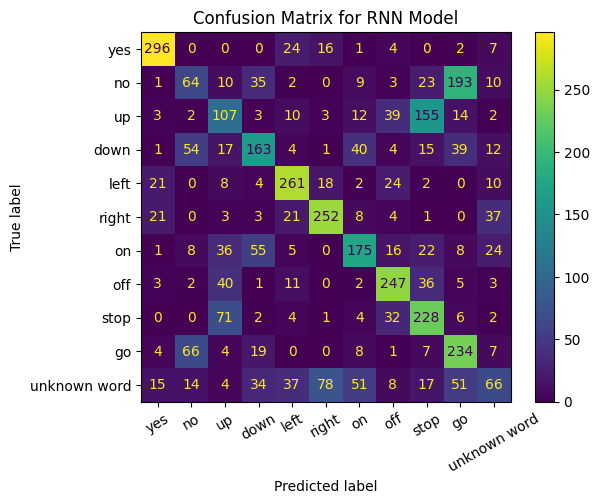

In [16]:
confusion_matrix(model_rnn_80, val_loader, "RNN Model")

### Entrenamiento del Modelo Vanilla RNN (Ventana de 120 ms)

In [23]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_120 = []
rnn_times_120 = []

for train_run in range(n_trains):
    model_rnn_120 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_120,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_120.append(curves)
    rnn_times_120.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_120):.2f} +- {np.std(rnn_times_120):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]


Tiempo total de entrenamiento: 342.6586 [s]
Tiempo de entrenamiento promedio de 1 corridas: 342.66 +- 0.00 [s]


Graficamos los resultados del entrenamiento

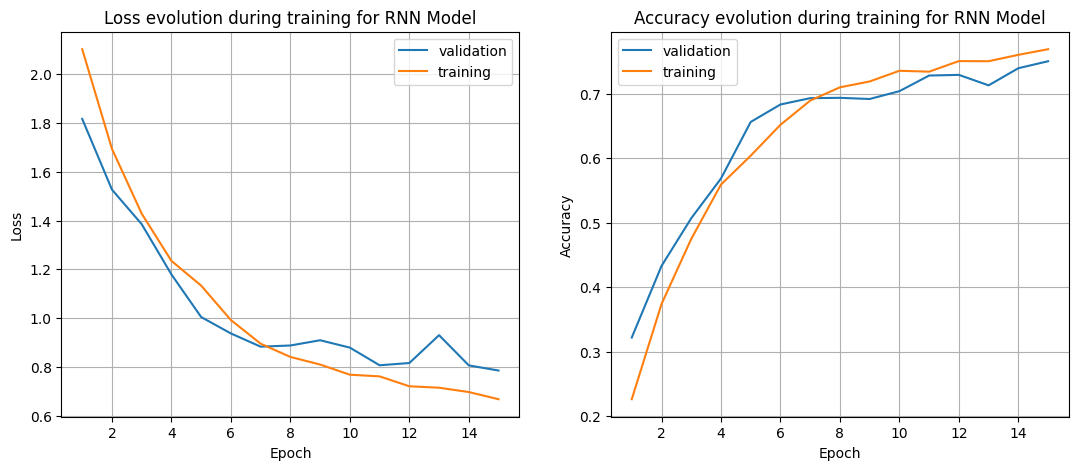

In [26]:
show_curves(rnn_all_curves_120, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 73.77%
Precision: 73.37%
Recall: 73.93%
F1-score: 72.63%


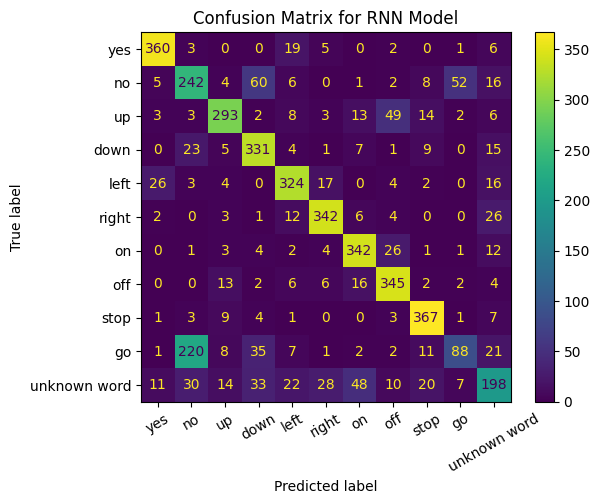

In [27]:
confusion_matrix(model_rnn_120, test_loader, "RNN Model")

RNN Model metrics

Accuracy: 75.23%
Precision: 75.42%
Recall: 75.38%
F1-score: 74.08%


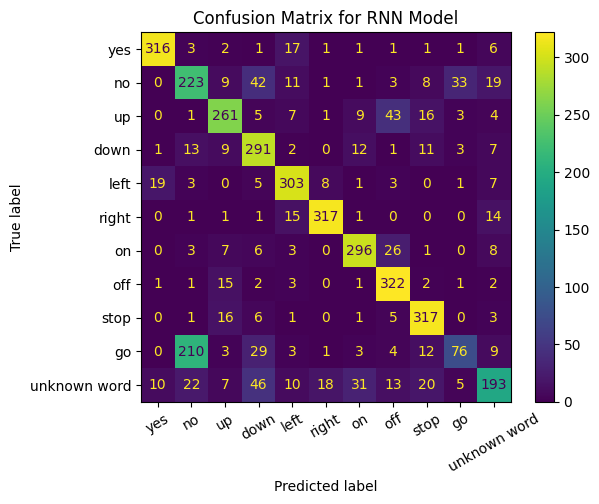

In [28]:
confusion_matrix(model_rnn_120, val_loader, "RNN Model")

# EXPORT


In [ ]:
max_len = max(len(lstm_all_curves[0]["val_acc"]), len(gru_all_curves[0]["val_acc"]), len(rnn_all_curves[0]["val_acc"]), len(rnn_all_curves_80[0]["val_acc"]),len(rnn_all_curves_120[0]["val_acc"]))

all_val_loss = [lstm_all_curves[0]["val_acc"], gru_all_curves[0]["val_acc"], rnn_all_curves[0]["val_acc"], rnn_all_curves_80[0]["val_acc"],rnn_all_curves_120[0]["val_acc"]]

for vloss in all_val_loss:

    if len(vloss) == max_len:
        continue

    ll = len(vloss)
    for _ in range(max_len-ll):
        vloss.append(vloss[-1])

vl = np.array(all_val_loss)



In [30]:
np.savetxt("data3.csv", vl,
              delimiter = ",")